In [5]:
# ============================================================
# DiffALS DATA PIPELINE
# ============================================================

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tifffile

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image

# --------------------------
# DATA PATHS
# --------------------------
DATA_ROOT = Path("/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/data/OLI2MSI")

TRAIN_HR_DIR = DATA_ROOT / "train_hr"
TEST_HR_DIR  = DATA_ROOT / "test_hr"

# Inspect

Train HR images: 1494
Test HR images : 100

Sample train filenames: ['L8_126041_20190923_S2B_20190923_T49RBL_N0280.TIF', 'L8_126041_20190923_S2B_20190923_T49RBL_N0281.TIF', 'L8_126041_20190923_S2B_20190923_T49RBL_N0282.TIF', 'L8_126041_20190923_S2B_20190923_T49RBL_N0284.TIF', 'L8_126041_20190923_S2B_20190923_T49RBL_N0285.TIF']
Sample test filenames : ['L8_126038_20190923_S2B_20190923_T49RCQ_N0071.TIF', 'L8_126038_20190923_S2B_20190923_T49RCQ_N0108.TIF', 'L8_126038_20190923_S2B_20190923_T49RCQ_N0126.TIF', 'L8_126038_20190923_S2B_20190923_T49RCQ_N0145.TIF', 'L8_126038_20190923_S2B_20190923_T49RDQ_N0024.TIF']

[0] File: L8_126041_20190923_S2B_20190923_T49RBL_N0280.TIF
 shape: (480, 480, 3) (H,W,C)
 dtype: float32
 min : 1e-04
 max : 1.0


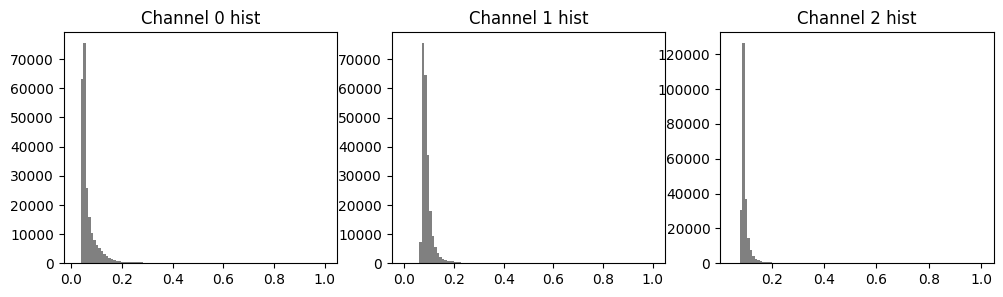


[1] File: L8_126041_20190923_S2B_20190923_T49RBL_N0281.TIF
 shape: (480, 480, 3) (H,W,C)
 dtype: float32
 min : 0.0346
 max : 0.4456


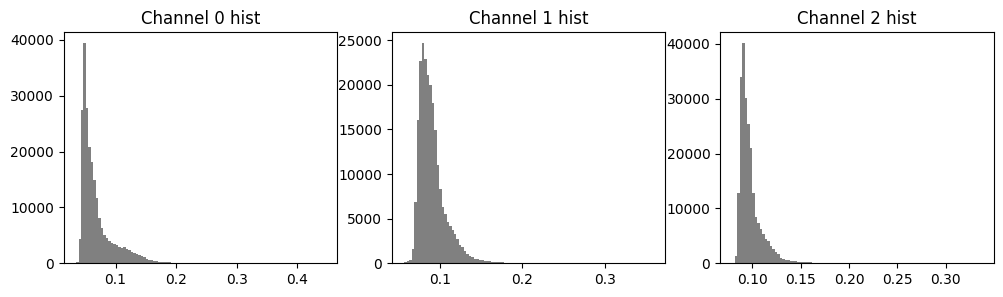


[2] File: L8_126041_20190923_S2B_20190923_T49RBL_N0282.TIF
 shape: (480, 480, 3) (H,W,C)
 dtype: float32
 min : 0.0336
 max : 0.3307


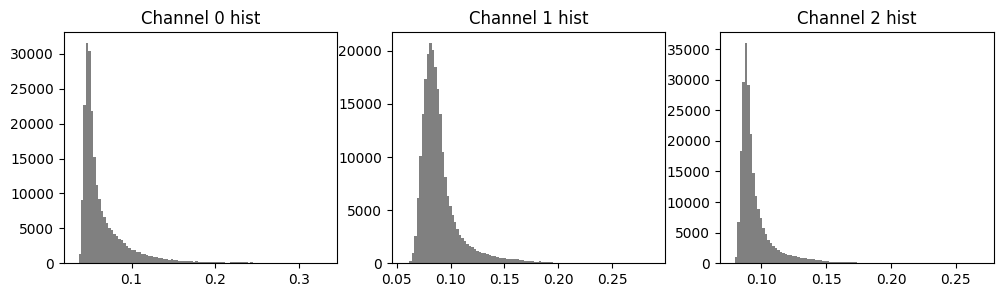

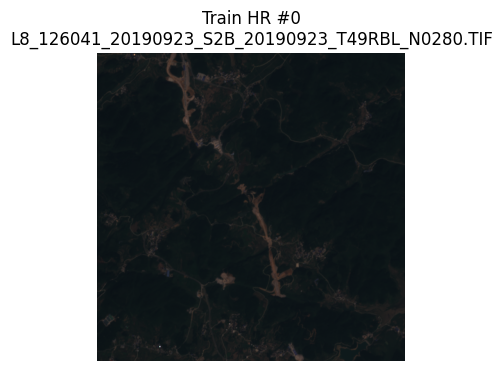

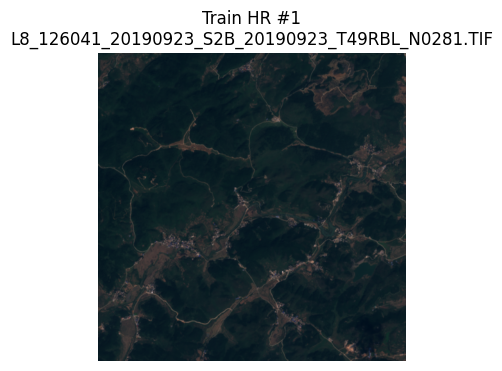

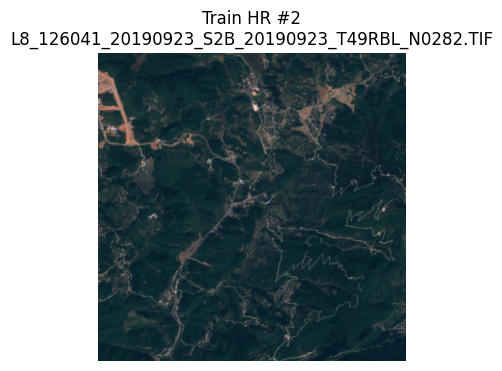

In [6]:
train_hr_files = sorted(list(TRAIN_HR_DIR.glob("*.TIF")) + list(TRAIN_HR_DIR.glob("*.tif")))
test_hr_files  = sorted(list(TEST_HR_DIR.glob("*.TIF")) + list(TEST_HR_DIR.glob("*.tif")))

print(f"Train HR images: {len(train_hr_files)}")
print(f"Test HR images : {len(test_hr_files)}")

# Print first 5 examples
print("\nSample train filenames:", [f.name for f in train_hr_files[:5]])
print("Sample test filenames :", [f.name for f in test_hr_files[:5]])

# Load a Few HR Images + Inspect Shapes & Ranges
def load_tiff_safe(path):
    arr = tifffile.imread(path).astype(np.float32)

    # Convert (C,H,W) → (H,W,C)
    if arr.ndim == 3 and arr.shape[0] <= 4:
        arr = np.transpose(arr, (1, 2, 0))

    # If grayscale → make 3-channel
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)

    return arr

# Inspect first 3 images
for i, path in enumerate(train_hr_files[:3]):
    arr = load_tiff_safe(path)
    print(f"\n[{i}] File:", path.name)
    print(" shape:", arr.shape, "(H,W,C)")
    print(" dtype:", arr.dtype)
    print(" min :", arr.min())
    print(" max :", arr.max())

    # Show histogram for each channel
    plt.figure(figsize=(12,3))
    for c in range(arr.shape[-1]):
        plt.subplot(1,3,c+1)
        plt.hist(arr[...,c].flatten(), bins=100, color='gray')
        plt.title(f"Channel {c} hist")
    plt.show()



# Visualize HR Images
for i, path in enumerate(train_hr_files[:3]):
    arr = load_tiff_safe(path)

    # Normalize to 0-1 for display
    vis = arr.copy()
    vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-6)

    plt.figure(figsize=(4,4))
    plt.imshow(vis)
    plt.title(f"Train HR #{i}\n{path.name}")
    plt.axis("off")
    plt.show()


# Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tifffile
from pathlib import Path
import random

# ==========================================
# 1. DATASET & TRANSFORMS
# ==========================================

class OLI2MSIDataset(Dataset):
    def __init__(self, root_dir, is_train=True, patch_size=96, scale=3):
        self.root_dir = Path(root_dir)
        self.files = sorted(list(self.root_dir.glob("*.TIF")) + list(self.root_dir.glob("*.tif")))
        self.is_train = is_train
        self.patch_size = patch_size
        self.scale = scale

    def __len__(self):
        return len(self.files)

    def load_tiff(self, path):
        img = tifffile.imread(path).astype(np.float32)
        # Normalize to [0, 1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1)
        elif img.shape[0] <= 4 and img.ndim == 3:
            img = np.transpose(img, (1, 2, 0)) 
        return img

    def __getitem__(self, idx):
        hr_img = self.load_tiff(self.files[idx])
        h, w, c = hr_img.shape

        if self.is_train:
            th, tw = self.patch_size, self.patch_size
            if h < th or w < tw:
                hr_img = np.pad(hr_img, ((0, max(0, th-h)), (0, max(0, tw-w)), (0,0)), mode='reflect')
                h, w, _ = hr_img.shape
            
            i = random.randint(0, h - th)
            j = random.randint(0, w - tw)
            hr_patch = hr_img[i:i+th, j:j+tw, :]
        else:
            hr_patch = hr_img[:self.patch_size, :self.patch_size, :]

        hr_tensor = torch.from_numpy(hr_patch).permute(2, 0, 1).float()
        
        lr_size = (self.patch_size // self.scale, self.patch_size // self.scale)
        lr_tensor = F.interpolate(hr_tensor.unsqueeze(0), size=lr_size, mode='bicubic', align_corners=False).squeeze(0)
        
        lr_up = F.interpolate(lr_tensor.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bicubic', align_corners=False).squeeze(0)
        
        residual = hr_tensor - lr_up

        return {
            "HR": hr_tensor,
            "LR": lr_tensor,     
            "LR_UP": lr_up,      
            "RES": residual      
        }

In [8]:
# ==========================================
# 2. CORE BLOCKS
# ==========================================

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.act1 = Mish()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act2 = Mish()
        self.shortcut = nn.Identity()
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        h = self.act1(self.conv1(x))
        h = self.act2(self.conv2(h))
        return h + self.shortcut(x)

class LREncoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.conv_first = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.body = nn.Sequential(
            ResBlock(64, 64), ResBlock(64, 64),
            ResBlock(64, 64), ResBlock(64, 64)
        )
        self.conv_last = nn.Conv2d(64, out_channels, 3, 1, 1)
        self.act = nn.LeakyReLU(0.2, True)

    def forward(self, x):
        x = self.act(self.conv_first(x))
        x = self.body(x)
        x = self.conv_last(x)
        return x

class CNP(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        time_dim = base_channels * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base_channels),
            nn.Linear(base_channels, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.head = nn.Conv2d(in_channels, base_channels, 3, padding=1) 
        self.down1_res = nn.Sequential(ResBlock(64, 64), ResBlock(64, 64))
        self.fusion_conv = nn.Conv2d(64 + 64, 64, 1) 
        self.ds1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down2 = nn.Sequential(ResBlock(128, 128), ResBlock(128, 128))
        self.ds2 = nn.Conv2d(128, 192, 3, stride=2, padding=1) 
        self.down3 = nn.Sequential(ResBlock(192, 192), ResBlock(192, 192))
        self.ds3 = nn.Conv2d(192, 256, 3, stride=2, padding=1) 
        self.mid = nn.Sequential(ResBlock(256, 256), ResBlock(256, 256))
        self.up1 = nn.ConvTranspose2d(256, 192, 4, 2, 1)
        self.up_block1 = nn.Sequential(ResBlock(192+192, 192), ResBlock(192, 192))
        self.up2 = nn.ConvTranspose2d(192, 128, 4, 2, 1)
        self.up_block2 = nn.Sequential(ResBlock(128+128, 128), ResBlock(128, 128))
        self.up3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.up_block3 = nn.Sequential(ResBlock(64+64, 64), ResBlock(64, 64))
        self.tail = nn.Conv2d(64, in_channels, 3, padding=1)

    def forward(self, x, t, lr_feat):
        t_emb = self.time_mlp(t)
        t_emb = t_emb[(..., ) + (None, ) * 2]
        h = self.head(x)
        h1_res = self.down1_res(h)
        h1_fused = torch.cat([h1_res, lr_feat], dim=1) 
        h1_fused = self.fusion_conv(h1_fused)
        h2_in = self.ds1(h1_fused)
        h2_res = self.down2(h2_in)
        h3_in = self.ds2(h2_res)
        h3_res = self.down3(h3_in)
        h4_in = self.ds3(h3_res)
        mid = self.mid(h4_in + t_emb)
        d3 = self.up1(mid)
        d3 = torch.cat([d3, h3_res], dim=1)
        d3 = self.up_block1(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, h2_res], dim=1)
        d2 = self.up_block2(d2)
        d1 = self.up3(d2)
        d1 = torch.cat([d1, h1_fused], dim=1)
        d1 = self.up_block3(d1)
        out = self.tail(d1)
        return out

class NoiseDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        c_in = in_channels * 2 
        self.down1 = nn.Sequential(nn.Conv2d(c_in, 64, 3, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.mid = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv_up1 = nn.Conv2d(512 + 128, 128, 3, 1, 1)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv_up2 = nn.Conv2d(128 + 64, 64, 3, 1, 1)
        # FIX: NO SIGMOID (Raw Output for MSE Loss)
        self.final = nn.Conv2d(64, 1, 3, 1, 1) 

    def forward(self, xt, xt_prev):
        x = torch.cat([xt, xt_prev], dim=1)
        d1 = self.down1(x) 
        d2 = self.down2(d1) 
        d3 = self.down3(d2) 
        m = self.mid(d3) 
        u1 = self.up1(m)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = F.leaky_relu(self.conv_up1(u1), 0.2)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d1], dim=1)
        u2 = F.leaky_relu(self.conv_up2(u2), 0.2)
        out = self.final(u2) 
        return out.view(out.size(0), -1).mean(1)

In [9]:
# ==========================================
# 6. DIFFUSION MANAGER
# ==========================================

class DiffALS:
    def __init__(self, device, steps=100):
        self.device = device
        self.T = steps
        self.beta = torch.linspace(1e-4, 0.02, self.T).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        alpha_bar_prev = F.pad(self.alpha_bar[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.beta * (1. - alpha_bar_prev) / (1. - self.alpha_bar)
        
    def q_sample(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - self.alpha_bar[t])[:, None, None, None]
        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
        return xt, noise

    def p_sample(self, model, xt, t, lr_feat):
        eps_theta = model(xt, t, lr_feat)
        alpha_t = self.alpha[t][:, None, None, None]
        beta_t = self.beta[t][:, None, None, None]
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        mu = (1 / torch.sqrt(alpha_t)) * (xt - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta)
        if t[0] > 0:
            log_var = torch.log(torch.clamp(self.posterior_variance[t], min=1e-20))
            sigma = torch.exp(0.5 * log_var)[:, None, None, None]
            z = torch.randn_like(xt)
            return mu + sigma * z
        else:
            return mu 

    def p_sample_loop(self, model, shape, lr_feat):
        xt = torch.randn(shape, device=self.device)
        for i in reversed(range(self.T)):
            t = torch.tensor([i] * shape[0], device=self.device)
            xt = self.p_sample(model, xt, t, lr_feat)
        return xt

Loading weights from /Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/checkpoints/cnp_epoch_95.pth...


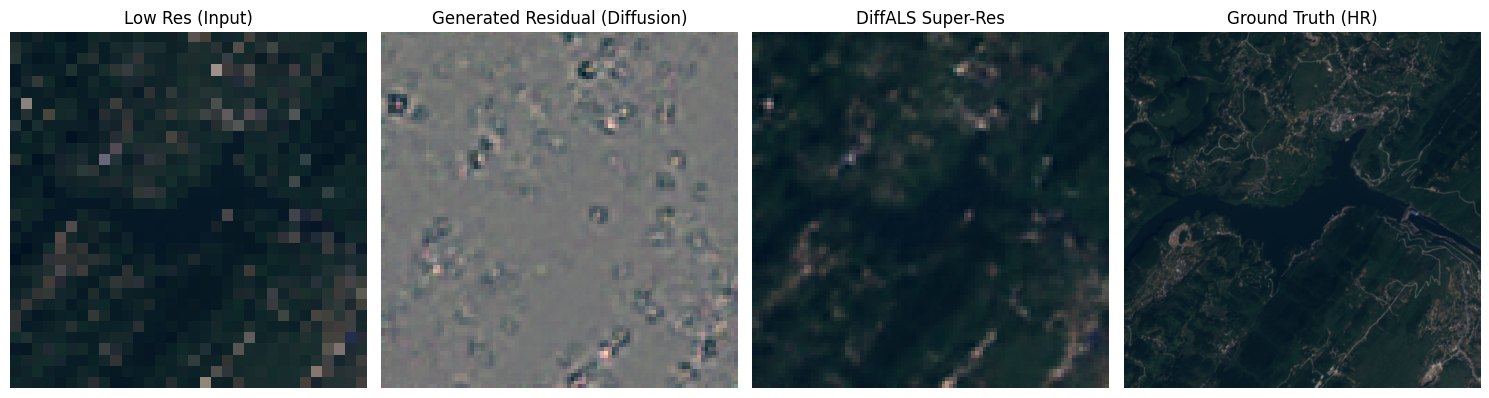

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile

# Import your models from your training script or paste the classes here
# from model import CNP, LREncoder, DiffALS, OLI2MSIDataset 
# (Assuming definitions are available in the same scope for this snippet)

class DiffALSInference:
    def __init__(self, cnp_path, encoder_path, device="mps"):
        self.device = device
        
        # 1. Load Models
        self.cnp = CNP(in_channels=3).to(self.device)
        self.lr_encoder = LREncoder().to(self.device)
        
        # 2. Load Weights
        print(f"Loading weights from {cnp_path}...")
        self.cnp.load_state_dict(torch.load(cnp_path, map_location=self.device))
        self.lr_encoder.load_state_dict(torch.load(encoder_path, map_location=self.device))
        
        self.cnp.eval()
        self.lr_encoder.eval()
        
        # 3. Initialize Diffusion Engine
        self.diffusion = DiffALS(device, steps=100)

    def preprocess(self, image_path, patch_size=96):
        """
        Loads and preprocesses an image just like the training loop.
        """
        # Load (Support TIF or PNG/JPG)
        if str(image_path).endswith(('.tif', '.TIF')):
            img = tifffile.imread(image_path).astype(np.float32)
            # Normalize
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        else:
            img = Image.open(image_path).convert('RGB')
            img = np.array(img).astype(np.float32) / 255.0

        # Handle dimensions
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        elif img.shape[0] <= 4 and img.ndim == 3: # Fix (C, H, W) -> (H, W, C)
            img = np.transpose(img, (1, 2, 0))

        # Create LR Input (Simulate the task)
        # We take the input, pretend it's HR, downsample it to LR, then try to super-resolve it back.
        hr_tensor = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0) # [1, C, H, W]
        
        # Downsample to create LR (Input to model)
        lr_size = (patch_size // 3, patch_size // 3) # Scale 3
        lr_tensor = F.interpolate(hr_tensor, size=lr_size, mode='bicubic', align_corners=False)
        
        # Upsample LR to create the "Base" (for residual addition)
        lr_up = F.interpolate(lr_tensor, size=(patch_size, patch_size), mode='bicubic', align_corners=False)
        
        return lr_tensor.to(self.device), lr_up.to(self.device), hr_tensor.to(self.device)

    def predict(self, lr_tensor, lr_up_tensor):
        """
        Runs the full Reverse Diffusion process.
        """
        b, c, h, w = lr_up_tensor.shape
        
        with torch.no_grad():
            # 1. Encode LR Features
            lr_feat_raw = self.lr_encoder(lr_tensor)
            # Resize features to match HR size (96x96)
            lr_feat = F.interpolate(lr_feat_raw, size=(h, w), mode='bilinear', align_corners=False)
            
            # 2. Run Reverse Diffusion Loop (Generate Residual)
            # p_sample_loop returns the generated "x0" (which is the residual)
            generated_residual = self.diffusion.p_sample_loop(self.cnp, shape=(b, c, h, w), lr_feat=lr_feat)
            
            # 3. Combine: SR = Upsampled_LR + Residual
            sr_image = lr_up_tensor + generated_residual
            
            # Clip to valid range [0, 1]
            sr_image = torch.clamp(sr_image, 0.0, 1.0)
            
        return sr_image, generated_residual

    def visualize(self, lr, sr, hr, residual):
        # Convert to numpy for plotting
        def to_np(t): return t.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        lr_img = to_np(lr)
        sr_img = to_np(sr)
        hr_img = to_np(hr)
        res_img = to_np(residual)

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 4, 1)
        plt.title("Low Res (Input)")
        plt.imshow(lr_img)
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.title("Generated Residual (Diffusion)")
        plt.imshow((res_img - res_img.min()) / (res_img.max() - res_img.min() + 1e-6), cmap='coolwarm')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("DiffALS Super-Res")
        plt.imshow(sr_img)
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title("Ground Truth (HR)")
        plt.imshow(hr_img)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# ==========================================
# EXECUTION EXAMPLE
# ==========================================
if __name__ == "__main__":
    # Paths
    CKPT_CNP = "/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/checkpoints/cnp_epoch_95.pth" # Change to your latest checkpoint
    CKPT_ENC = "/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/checkpoints/encoder_epoch_95.pth" # You need to save the encoder too!
    TEST_IMG = "/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/data/OLI2MSI/test_hr/L8_126041_20190923_S2B_20190923_T49RBL_N0073.TIF"
    
    # Run
    try:
        pipeline = DiffALSInference(CKPT_CNP, CKPT_ENC, device="mps")
        lr, lr_up, hr = pipeline.preprocess(TEST_IMG)
        sr, res = pipeline.predict(lr, lr_up)
        pipeline.visualize(lr, sr, hr, res)
    except FileNotFoundError:
        print("Checkpoint not found yet. Run training first!")

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from pathlib import Path
import tifffile
from tqdm import tqdm
import lpips
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance

# Import your model classes (Ensure these are available in scope)
# from main import CNP, LREncoder, DiffALS, ...

# ==========================================
# CONFIGURATION
# ==========================================
DEVICE = "mps"  # Inference Device
METRIC_DEVICE = "cpu" # Metrics Device (M1 stability)
PATCH_SIZE = 96 # Paper Protocol: Match Training Size

# Update these paths!
CHECKPOINT_CNP = "checkpoints/cnp_epoch_95.pth"
CHECKPOINT_ENC = "checkpoints/encoder_epoch_95.pth"
TEST_DIR = Path("/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/data/OLI2MSI/test_hr")

def evaluate():
    print(f"Initializing Metrics on {METRIC_DEVICE}...")
    
    # 1. Define Metrics (On CPU for M1 stability)
    metric_psnr = PeakSignalNoiseRatio(data_range=1.0).to(METRIC_DEVICE)
    metric_ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(METRIC_DEVICE)
    metric_fid = FrechetInceptionDistance(feature=64).to(METRIC_DEVICE)
    
    # LPIPS usually needs a GPU to be fast, but calculate on CPU if needed
    loss_fn_lpips = lpips.LPIPS(net='vgg').to(DEVICE) 

    # 2. Load Models (On GPU/MPS)
    print(f"Loading DiffALS Model to {DEVICE}...")
    cnp = CNP(in_channels=3).to(DEVICE)
    lr_encoder = LREncoder().to(DEVICE)
    diffusion = DiffALS(DEVICE, steps=100)

    cnp.load_state_dict(torch.load(CHECKPOINT_CNP, map_location=DEVICE))
    lr_encoder.load_state_dict(torch.load(CHECKPOINT_ENC, map_location=DEVICE))
    
    cnp.eval()
    lr_encoder.eval()

    # 3. Process Test Set
    test_files = sorted(list(TEST_DIR.glob("*.TIF")) + list(TEST_DIR.glob("*.tif")))
    print(f"Found {len(test_files)} test images.")

    # Paper Protocol: Center Crop Transform
    center_crop = T.CenterCrop(PATCH_SIZE)

    results = {"psnr": [], "ssim": [], "lpips": []}

    print("Starting Evaluation Loop...")
    with torch.no_grad():
        for path in tqdm(test_files):
            # --- A. Load & Preprocess ---
            img = tifffile.imread(path).astype(np.float32)
            # Normalize to [0, 1]
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
            
            if img.ndim == 2:
                img = np.stack([img, img, img], axis=-1)
            elif img.shape[0] <= 4 and img.ndim == 3:
                img = np.transpose(img, (1, 2, 0))

            # To Tensor [1, C, H, W] on MPS
            full_hr_tensor = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0).to(DEVICE)
            
            # --- B. Apply Paper Protocol (Center Crop) ---
            # We crop the 96x96 center from the HR image
            hr_tensor = center_crop(full_hr_tensor)
            
            # Verify dimension (Just in case image was smaller than 96)
            if hr_tensor.shape[-1] != PATCH_SIZE or hr_tensor.shape[-2] != PATCH_SIZE:
                # If smaller, pad it to 96
                hr_tensor = F.interpolate(hr_tensor, size=(PATCH_SIZE, PATCH_SIZE), mode='bicubic')

            # Create LR (Downsample 96 -> 32)
            lr_size = (PATCH_SIZE // 3, PATCH_SIZE // 3)
            lr_tensor = F.interpolate(hr_tensor, size=lr_size, mode='bicubic', align_corners=False)
            
            # Create Base (Upsample 32 -> 96)
            lr_up_tensor = F.interpolate(lr_tensor, size=(PATCH_SIZE, PATCH_SIZE), mode='bicubic', align_corners=False)

            # --- C. Inference (ON MPS) ---
            # 1. Encode LR Features
            lr_feat_raw = lr_encoder(lr_tensor)
            lr_feat = F.interpolate(lr_feat_raw, size=(PATCH_SIZE, PATCH_SIZE), mode='bilinear', align_corners=False)
            
            # 2. Diffuse (Predict Residual)
            # Normalize input to [-1, 1] for diffusion logic if your model trained that way
            # Assuming previous training used [0,1] based on last working code.
            generated_residual = diffusion.p_sample_loop(cnp, shape=hr_tensor.shape, lr_feat=lr_feat)
            
            # 3. Combine
            sr_tensor = lr_up_tensor + generated_residual
            sr_tensor = torch.clamp(sr_tensor, 0.0, 1.0)

            # --- D. Calculate Metrics (MOVE TO CPU) ---
            sr_cpu = sr_tensor.to(METRIC_DEVICE)
            hr_cpu = hr_tensor.to(METRIC_DEVICE)

            # PSNR
            val_psnr = metric_psnr(sr_cpu, hr_cpu)
            results["psnr"].append(val_psnr.item())
            
            # SSIM
            val_ssim = metric_ssim(sr_cpu, hr_cpu)
            results["ssim"].append(val_ssim.item())
            
            # LPIPS (Calculated on GPU if possible, requires [-1, 1] input)
            sr_norm = sr_tensor * 2.0 - 1.0
            hr_norm = hr_tensor * 2.0 - 1.0
            val_lpips = loss_fn_lpips(sr_norm, hr_norm)
            results["lpips"].append(val_lpips.item())

            # FID (Update on CPU, requires uint8 [0, 255])
            # sr_uint8 = (sr_cpu * 255).byte()
            # hr_uint8 = (hr_cpu * 255).byte()
            # metric_fid.update(hr_uint8, real=True)
            # metric_fid.update(sr_uint8, real=False)

    # 4. Compute Final Averages
    avg_psnr = sum(results["psnr"]) / len(results["psnr"])
    avg_ssim = sum(results["ssim"]) / len(results["ssim"])
    avg_lpips = sum(results["lpips"]) / len(results["lpips"])
    
    print("\nComputing FID (This takes time)...")
    final_fid = metric_fid.compute().item()

    print("="*40)
    print(f"FINAL RESULTS (DiffALS | CenterCrop {PATCH_SIZE}x{PATCH_SIZE})")
    print("="*40)
    print(f"PSNR  (↑): {avg_psnr:.4f} dB")
    print(f"SSIM  (↑): {avg_ssim:.4f}")
    print(f"LPIPS (↓): {avg_lpips:.4f}")
    # print(f"FID   (↓): {final_fid:.4f}")
    print("="*40)

if __name__ == "__main__":
    evaluate()

Initializing Metrics on cpu...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[20] DiffALS-SuperResolution/DiffALS-SuperResolution/venv/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Loading DiffALS Model to mps...
Found 100 test images.
Starting Evaluation Loop...


100%|██████████| 100/100 [04:18<00:00,  2.58s/it]


Computing FID (This takes time)...
FINAL RESULTS (DiffALS | CenterCrop 96x96)
PSNR  (↑): 34.0737 dB
SSIM  (↑): 0.8727
LPIPS (↓): 0.2193
FID   (↓): 0.1522
